In [1]:
import ENDFtk
import ACEtk
import scion

import matplotlib.pyplot as plot
%matplotlib notebook

In [2]:
# the files we want to look at
endffile = 'resources/n-001_H_001-endf80.endf'
acefile = 'resources/n-001_H_001-endf80.ace'    # Lib80x at 0.1 K (1001.805c)

In [3]:
# a few functions we need (these will be integrated into scion when from_endf(...) becomes available)

# convert to the proper Legendre coefficients
def convert( coefficients ) :
    
    converted = [ 0.5 ]
    for i in range( 1, len( coefficients ) + 1 ) :
        
        converted.append( ( 2 * i + 1 ) / 2 * coefficients[i - 1] )
    
    return converted

In [4]:
# open the ENDF file and retrieve the capture cross section
tape = ENDFtk.tree.Tape.from_file( endffile )
endf_elastic = tape.materials.front().file( 4 ).section( 2 ).parse()

print( 'number incident energies: ', len( endf_elastic.angular_distributions ) )

number incident energies:  153


In [5]:
# retrieve the ENDF data for 20 MeV
index = -1

incident_energy = endf_elastic.incident_energies[index]
endf_legendre = scion.math.LegendreSeries( convert( endf_elastic.angular_distributions[index].coefficients ) )

print( 'order: ', endf_legendre.order )
print( 'coefficients: ', endf_legendre.coefficients )

order:  6
coefficients:  [0.5, -0.02419452, 0.0195173075, -0.0027194370000000003, 0.0016944974999999998, 5.2521997e-05, 4.48370065e-05]


In [6]:
# open the ACE file and retrieve the elastic angular distribution data
ace = ACEtk.ContinuousEnergyTable.from_file( acefile )

# reaction index = 0 for elastic (it's an ACE things)
ace_elastic = ace.angular_distribution_block.angular_distribution_data( 0 ).distributions[index]

print( 'zaid: ', ace.header.zaid )
print( 'temperature: ', ace.header.temperature )
print( 'number points: ', len( ace_elastic.cosines ) )

zaid:  1001.805nc
temperature:  8.6174e-12
number points:  8


<IPython.core.display.Javascript object>


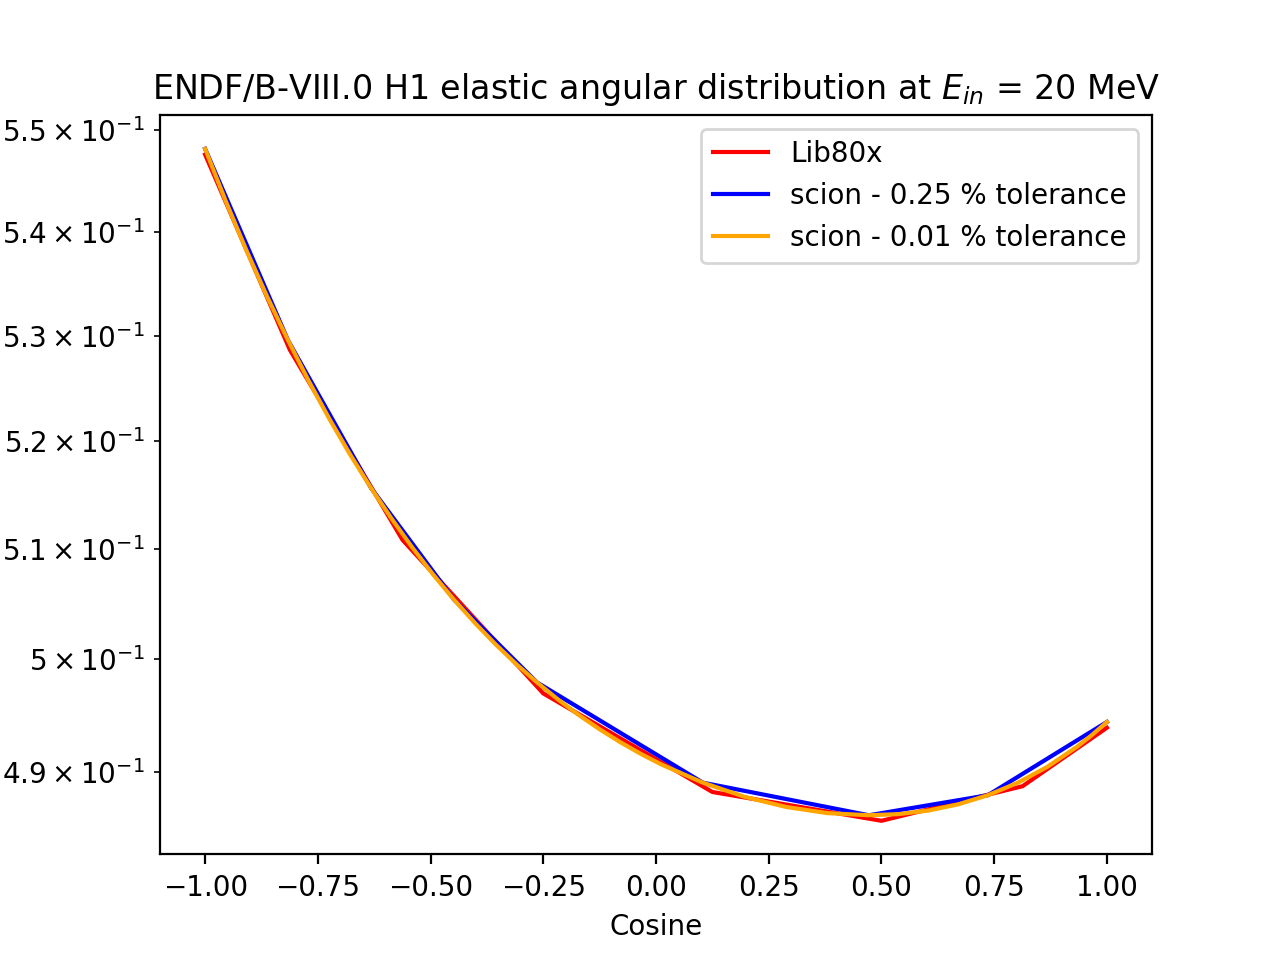

In [7]:
# linearise the pdf at different tolerances
plot1 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_elastic.cosines, ace_elastic.pdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()
plot.savefig('test.png')

In [8]:
print( len( ace_elastic.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

8
9
37


<IPython.core.display.Javascript object>


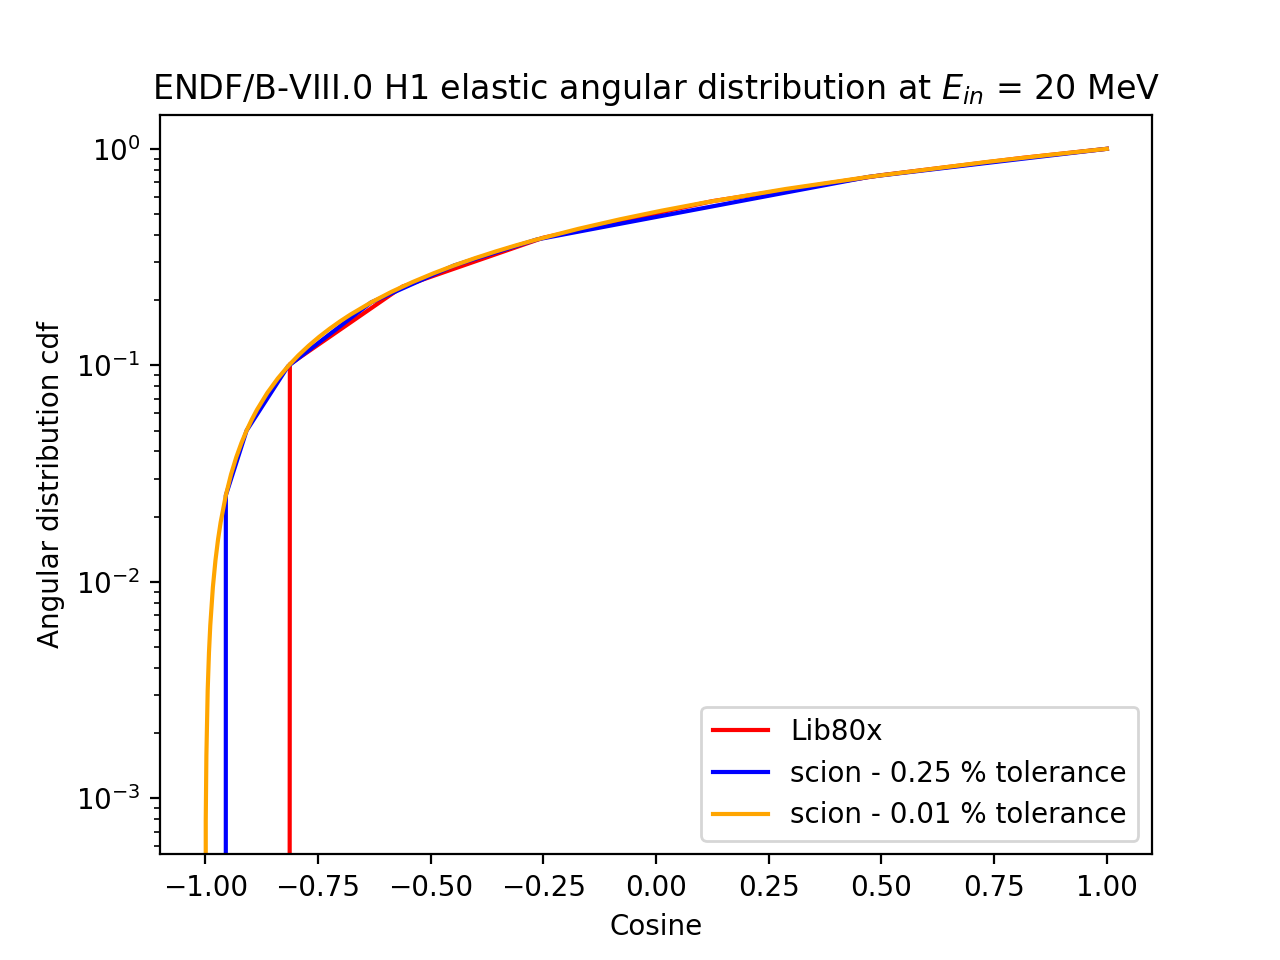

In [9]:
# we can linearise the cdf directly based on the primitive of the pdf as a Legendre series
endf_cdf = endf_legendre.primitive( -1.0 ) # the integral[-1,x] of the endf_legendre series

plot1 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_elastic.cosines, ace_elastic.cdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution cdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [10]:
print( len( ace_elastic.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

8
9
44


In [11]:
# we can verify that the pdf never goes below zero in [-1,1] by calculating the roots of the pdf on the real axis
print( 'roots: ', endf_legendre.roots() )

roots:  []


In [12]:
# we can verify that the cdf is monotonically increasing in [-1,1] by calculating the roots of the 
# first derivative of the cdf on the real axis and showing that the derivative is always above zero
# and yes: I know that boils down to calculating the roots of the pdf but I'm flexing the interface here :-)
print( 'roots: ', endf_legendre.primitive( -1 ).derivative().roots() )

roots:  []


In [13]:
# more fun: calculate the point where the distance between the pdf and the linear approximation is highest
x = [ -1, 1 ]
y = [ endf_legendre(-1), endf_legendre(1) ]

slope = ( y[1] - y[0] ) / ( x[1] - x[0] )

# the distance between the line and the actual pdf is maximum where d/dx( f(x) - slope * x + b ) = 0
# or df/dx = slope
cosines = endf_legendre.derivative().roots( a = slope )
print( 'min and max distance points: ', cosines )

min and max distance points:  [-0.13715028896666442]


<IPython.core.display.Javascript object>


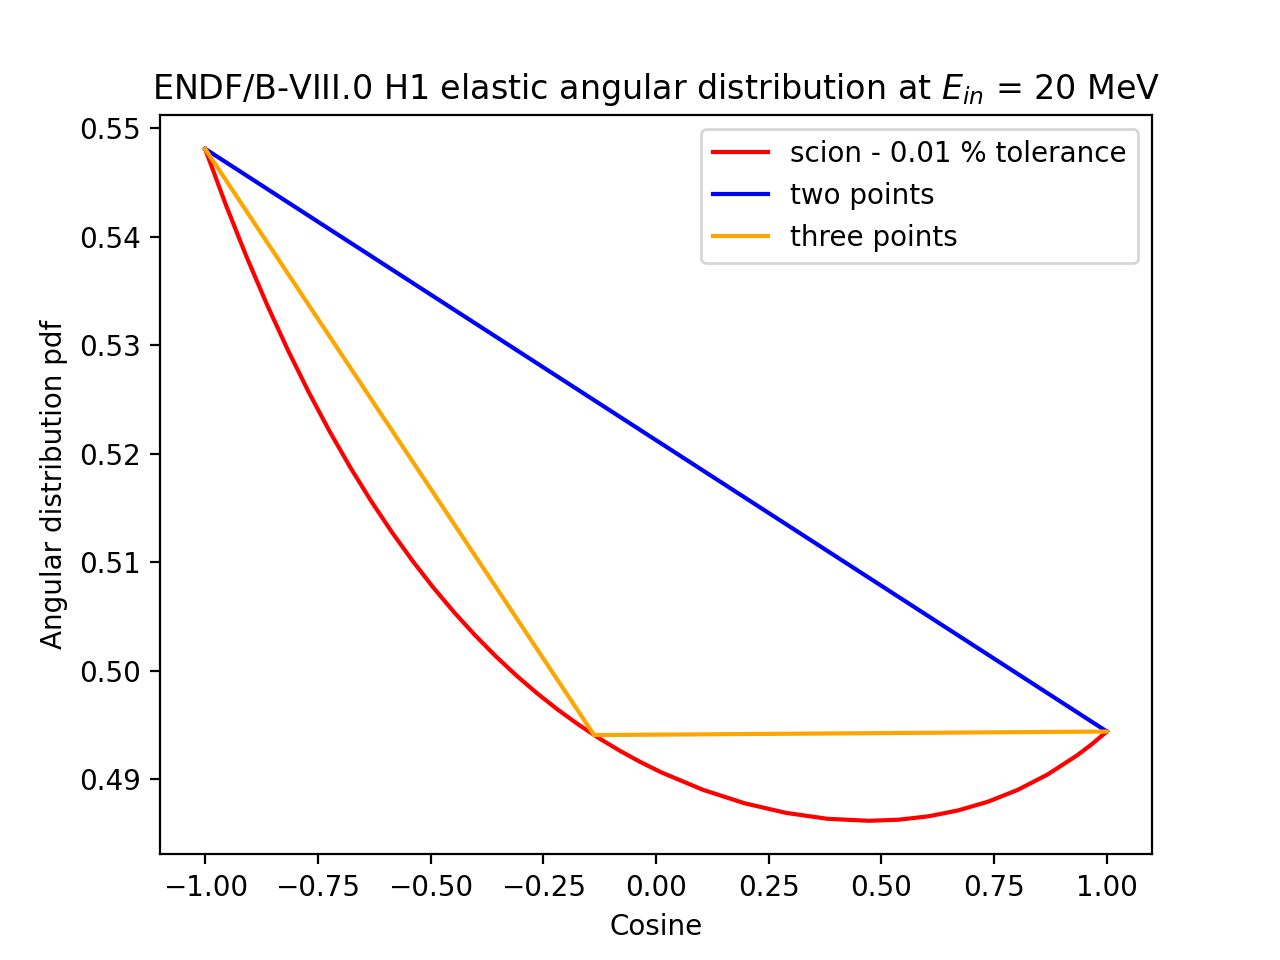

In [14]:
cosines += [ -1., 1. ]
cosines.sort()
values = [ endf_legendre( cosine ) for cosine in cosines ]

plot2 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'red', linewidth = 1.5 )
plot.plot( x, y, label = 'two points', color = 'blue', linewidth = 1.5 )
plot.plot( cosines, values, label = 'three points', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'linear' )
plot.legend()
plot.show()
plot.savefig('test.png')

In [15]:
distance = endf_legendre( cosines[1] ) - ( slope * ( x[1] - x[0] ) + y[0] )

print( distance )
print( slope )
print( endf_legendre.derivative()( cosines[1] ) )

-0.0003293997516063407
-0.026861435003000006
-0.02686143500299989
